In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score,r2_score
import itertools
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

In [2]:
data = "processed_dataset.csv"
# processed_dataset_powerprod.csv       Classifies outliers, this means additional features in model, with the goal of fitting the model better to power production
# processed_dataset.csv      This file deletes all outliers, max pre-processing, deletes cp values etc

DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"

data17 = pd.read_excel(DATA17, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

merged_df17 = pd.merge(datascada17, data17, on="Timestamp", how="inner")

In [3]:
merged_df = pd.read_csv(data)

the csv file is a preprocessed file, which was processed using rules from analysis of the power production

scada data from 2017 needs to be preprocessed as well:
- t07 turbine should only be evaluated (see below)

In [4]:
#t07 is selected
merged_df17 = merged_df17[merged_df17["Turbine_ID"] == "T07"]

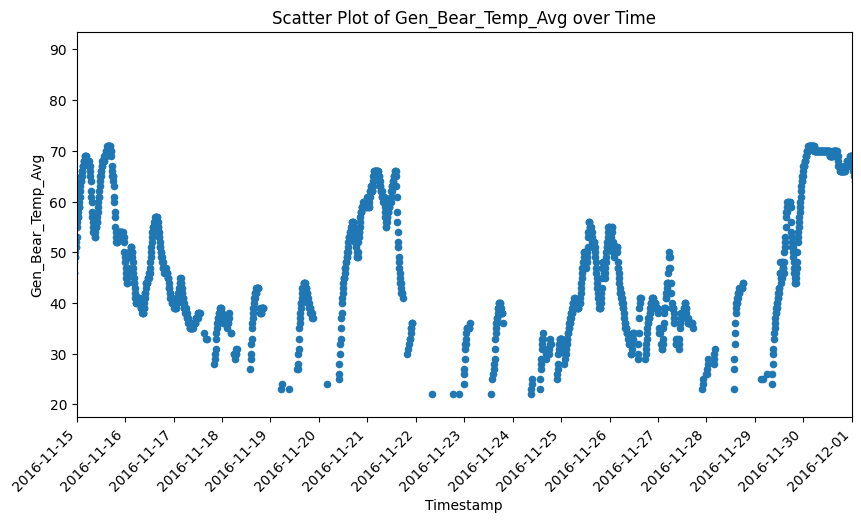

In [5]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


## Custom features

In [6]:
# creating data columns for the xgboost regressor

# Air density

# acceleration last x seconds

# Can we implement average speed for the last 30 minutes

# C_p?

# tip speed ratio

# Angle of blades

# Wind direction

# wind speed modified for distributed wind speed on diameter of blade

Air density 

In [7]:


# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df["T"] = merged_df["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df["p"] = merged_df["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df["e_s"] = 6.112 * np.exp((17.67 * merged_df["Amb_Temp_Avg"]) / (merged_df["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df["RH_frac"] = merged_df["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df["p_v"] = merged_df["RH_frac"] * merged_df["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df["p_d"] = merged_df["p"] - merged_df["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df["airdensity"] = (merged_df["p_d"] / (R_d * merged_df["T"])) + (merged_df["p_v"] / (R_v * merged_df["T"]))

# Optionally, drop intermediate columns if not needed
merged_df.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df[["airdensity"]].head())


   airdensity
0    1.193996
1    1.203438
2    1.203356
3    1.204229
4    1.194742


In [8]:
# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df17["T"] = merged_df17["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df17["p"] = merged_df17["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df17["e_s"] = 6.112 * np.exp((17.67 * merged_df17["Amb_Temp_Avg"]) / (merged_df17["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df17["RH_frac"] = merged_df17["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df17["p_v"] = merged_df17["RH_frac"] * merged_df17["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df17["p_d"] = merged_df17["p"] - merged_df17["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df17["airdensity"] = (merged_df17["p_d"] / (R_d * merged_df17["T"])) + (merged_df17["p_v"] / (R_v * merged_df17["T"]))

# Optionally, drop intermediate columns if not needed
merged_df17.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df17[["airdensity"]].head())


    airdensity
3     1.221427
12    1.225975
19    1.225897
21    1.226208
22    1.226286


(-50.0, 2100.0)

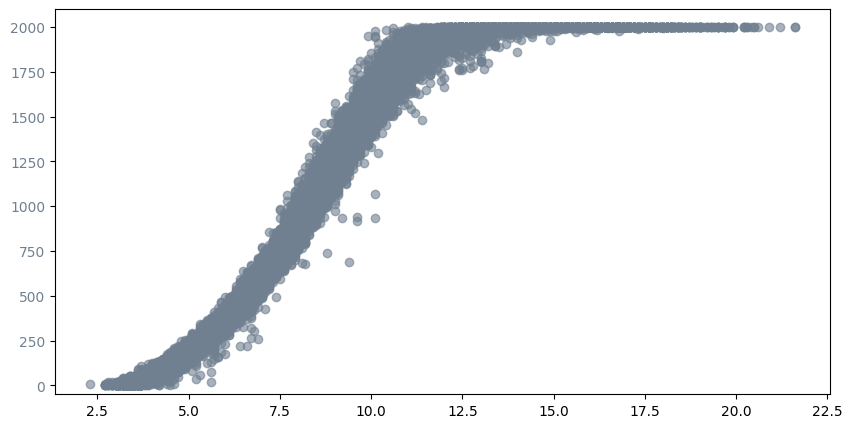

In [9]:
# Create a secondary y-axis with a slate gray color
plt.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["Grd_Prod_Pwr_Avg"], color='slategray', label='Wind Power (W)', alpha=0.6)  # Muted slate gray color
  # Secondary y-axis label color
plt.tick_params(axis='y', labelcolor='slategray')  # Secondary y-axis label tick color
plt.ylim(-50, 2100)


### TSR 2016

In [10]:
# Tip Speed Ratio (TSR)

conversion_factor = 2 * np.pi / 60
rotor_diameter = 90

merged_df["tsr"] = (merged_df["Rtr_RPM_Avg"]* conversion_factor) * (rotor_diameter/2) / merged_df["Amb_WindSpeed_Avg"]

merged_df = merged_df[merged_df["Amb_WindSpeed_Avg"] != 0]

### TSR 2017

In [11]:
# Tip Speed Ratio (TSR)

conversion_factor = 2 * np.pi / 60
rotor_diameter = 90

merged_df17["tsr"] = (merged_df17["Rtr_RPM_Avg"]* conversion_factor) * (rotor_diameter/2) / merged_df17["Amb_WindSpeed_Avg"]

merged_df17 = merged_df17[merged_df17["Amb_WindSpeed_Avg"] != 0]

In [12]:
# calculate wind power column
# Calculate actual cp

"""Amb_Temp_Avg, Avg_AmbientTemp"""
Arotor = 6362 #m^2 rotor area

# new column for power in the wind itself. 
merged_df["p_wind"] = 0.5*merged_df["airdensity"]*Arotor*(merged_df["Amb_WindSpeed_Avg"]**3)/1000 #kW

merged_df = merged_df[merged_df["p_wind"] != 0]
# cp = p_turbine / p_wind
merged_df["cp_actual"] =  merged_df["Grd_Prod_Pwr_Avg"] / merged_df["p_wind"]

merged_df = merged_df[merged_df["cp_actual"] != 0]

In [13]:
# calculate wind power column
# Calculate actual cp

# new column for power in the wind itself. 
merged_df17["p_wind"] = 0.5*merged_df17["airdensity"]*Arotor*(merged_df17["Amb_WindSpeed_Avg"]**3)/1000 #kW


## Xgboost model:

In [ ]:
# Step 2: Specify the feature columns and the target variable
feature_columns = ["airdensity", "Amb_WindSpeed_Avg"]  # Features
target_column = 'Grd_Prod_Pwr_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions

# Step 5: Initialize the XGBoost model with optimal hyperparameters
model = XGBRegressor()


# Step 6: Train the model
model.fit(X_train, y_train)


# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)


# Step 8: Evaluate the model on merged_df (Optional)
train_predictions = model.predict(X_train)


# Check if the target variable is binary (classification)
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # Regression Metrics
    mse = mean_squared_error(y_train, train_predictions)
    mae = mean_absolute_error(y_train, train_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train, train_predictions)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100
    
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions


Mean Squared Error (MSE): 747.83
Mean Absolute Error (MAE): 18.74
Root Mean Squared Error (RMSE): 27.35
R² Score: 1.00
Mean Absolute Percentage Error (MAPE): 15.60%


In [15]:
# mean error of hybrid model
y_difference_xgboost = merged_df17["xgboost_pred_2017"] - merged_df17["Grd_Prod_Pwr_Avg"]

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error_xgboost = np.abs(np.mean(y_difference_xgboost))
modelling_error_xgboost

np.float64(17.256925358115456)

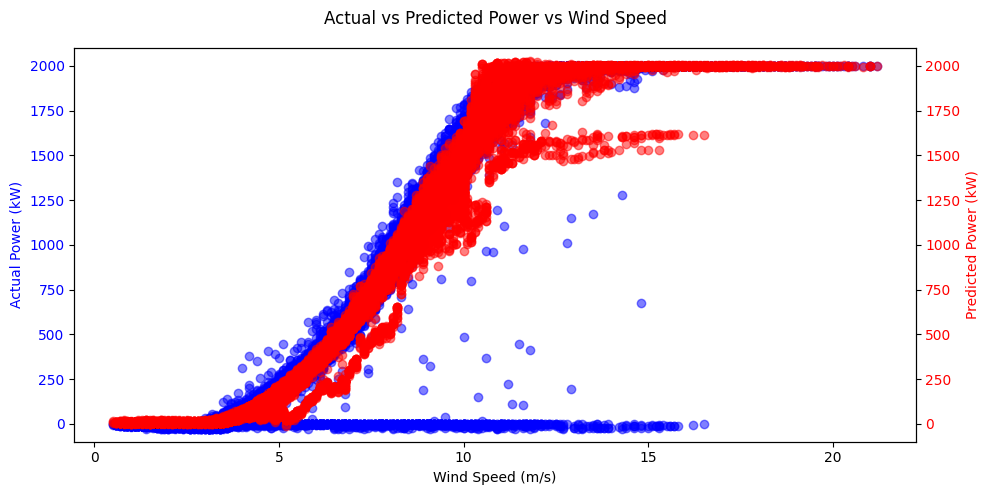

In [16]:
import matplotlib.pyplot as plt

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = merged_df17["Amb_WindSpeed_Avg"]  # Wind speed (X-axis)
y_actual = merged_df17["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = merged_df17["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="blue")
ax1.scatter(x, y_actual, color="blue", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="blue")
plt.ylim(-100,2100)
# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="red")
ax2.scatter(x, y_predicted, color="red", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="red")


# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed")
fig.tight_layout()
plt.ylim(-100,2100)
plt.show()


### What does this look for a smaller period

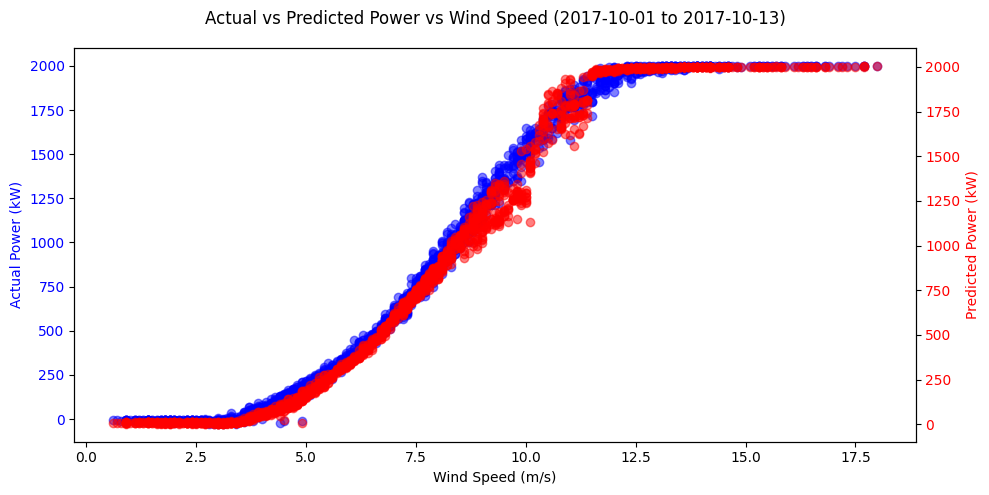

In [17]:
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Filter data for the date range 2017-10-01 to 2017-10-13
filtered_df = merged_df17[(merged_df17["Timestamp"] >= "2017-10-01") & 
                          (merged_df17["Timestamp"] <= "2017-10-13")]

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = filtered_df["Amb_WindSpeed_Avg"]  # Wind speed (X-axis)
y_actual = filtered_df["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = filtered_df["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="blue")
ax1.scatter(x, y_actual, color="blue", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="red")
ax2.scatter(x, y_predicted, color="red", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="red")

# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed (2017-10-01 to 2017-10-13)")
fig.tight_layout()
plt.show()


### Error calculation

In [18]:
# error models

# total error = model error + sensor error + actual error + operational error



# mean error
y_difference = y_predicted-y_actual

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error_xgboost_inference_test = np.abs(np.mean(y_difference))

In [19]:
modelling_error_xgboost_inference_test

np.float64(13.534751758911902)

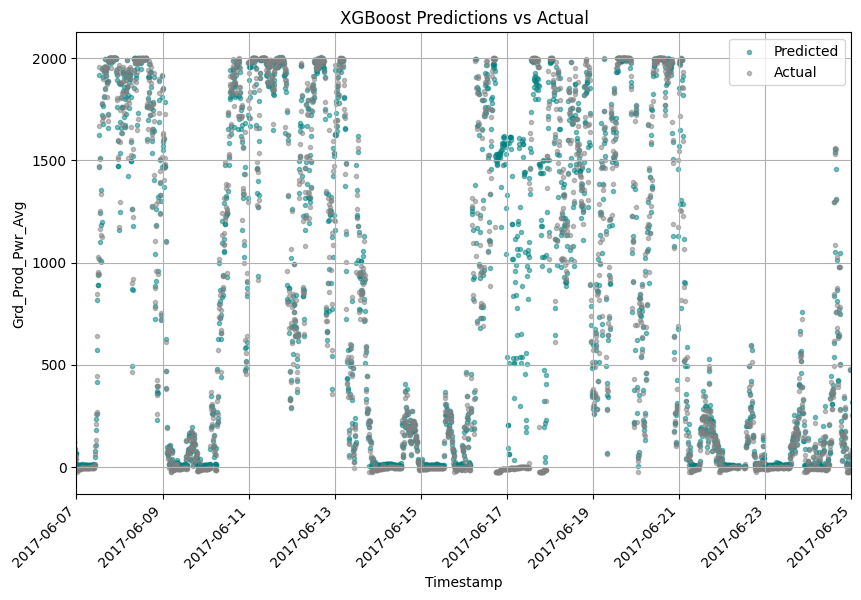

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions stored in 'cp_xgboost'
    c='teal', alpha=0.5, label='Predicted', marker="."
)

# Scatter plot for actual values (y_test)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='grey', alpha=0.5, label='Actual', marker=".", 
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()


## Set maximum power here:

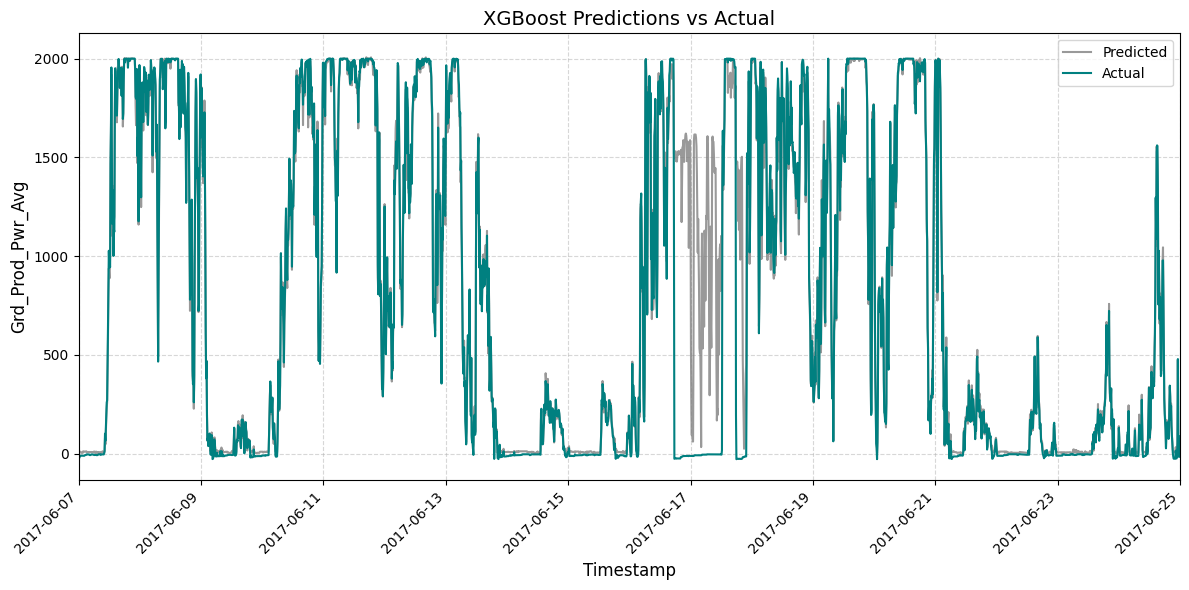

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


Replication of maneesh work to see if data is faulty after maintenance in

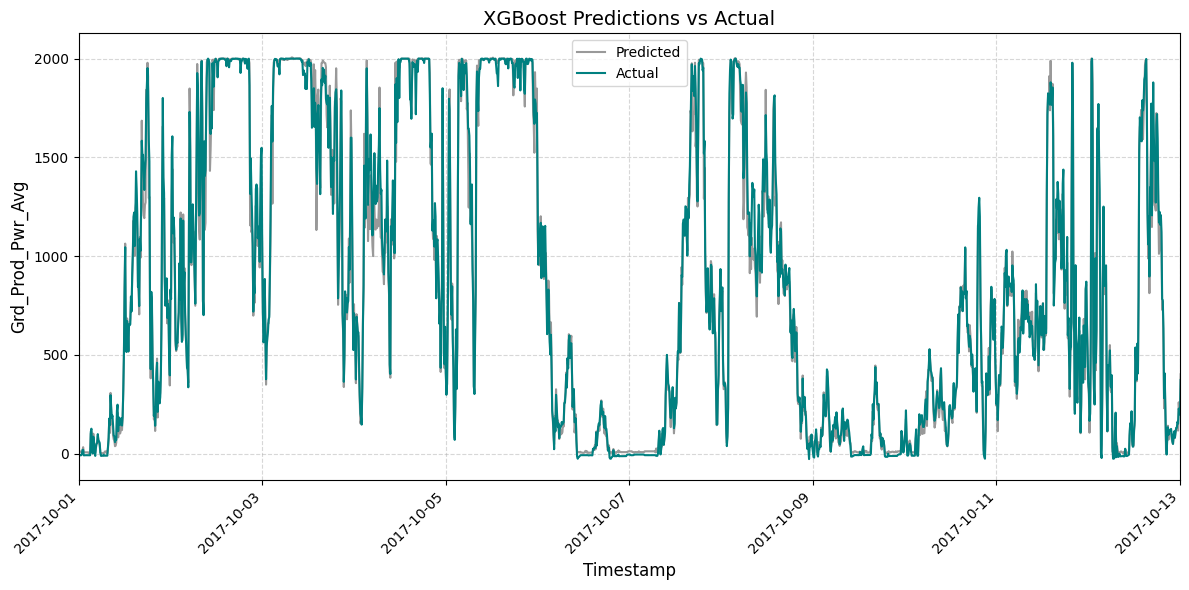

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


(np.float64(17324.0), np.float64(17525.0))

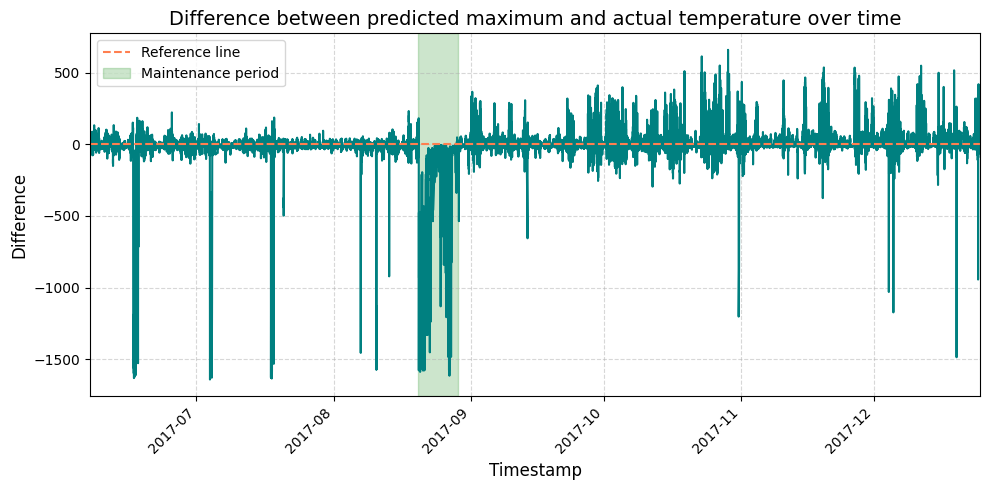

In [23]:
merged_df_filtered17_sorted["xgb_actual_diff"] =  merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]

plt.plot(merged_df_filtered17_sorted["Timestamp"],merged_df_filtered17_sorted["xgb_actual_diff"], color="teal")

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Reference line")
# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")
# Configure plot
plt.title("Difference between predicted maximum and actual temperature over time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Difference", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

In [24]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Compute the difference between actual and predicted values for the hybrid model
merged_df_filtered17_sorted["hybrid_actual_diff"] = merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["p_hybrid"]

# Plot the difference over time
plt.plot(merged_df_filtered17_sorted["Timestamp"], merged_df_filtered17_sorted["hybrid_actual_diff"], color="teal")

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Reference line")

# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")

# Configure plot
plt.title("Difference between Predicted and Actual Temperature Over Time (Hybrid Model)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Difference", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Set x-axis limits
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Compute the difference between actual and predicted values for the hybrid model\nmerged_df_filtered17_sorted["hybrid_actual_diff"] = merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["p_hybrid"]\n\n# Plot the difference over time\nplt.plot(merged_df_filtered17_sorted["Timestamp"], merged_df_filtered17_sorted["hybrid_actual_diff"], color="teal")\n\n# Add reference line for anomaly threshold\nplt.axhline(y=0, color=\'coral\', linestyle="--", label="Reference line")\n\n# Add green shaded region between specified dates\nplt.axvspan(pd.to_datetime(\'2017-08-20\'), pd.to_datetime(\'2017-08-29\'), color=\'green\', alpha=0.2, label="Maintenance period")\n\n# Configure plot\nplt.title("Difference between Predicted and Actual Temperature Over Time (Hybrid Model)", fontsize=14)\nplt.xlabel("Timestamp", fontsize=12)\nplt.ylabel("Difference", fontsize=12)\nplt.legend(fontsize=10)\nplt.grid(True, linestyle=\'--\', alph

Test of wide interval without uncertainty

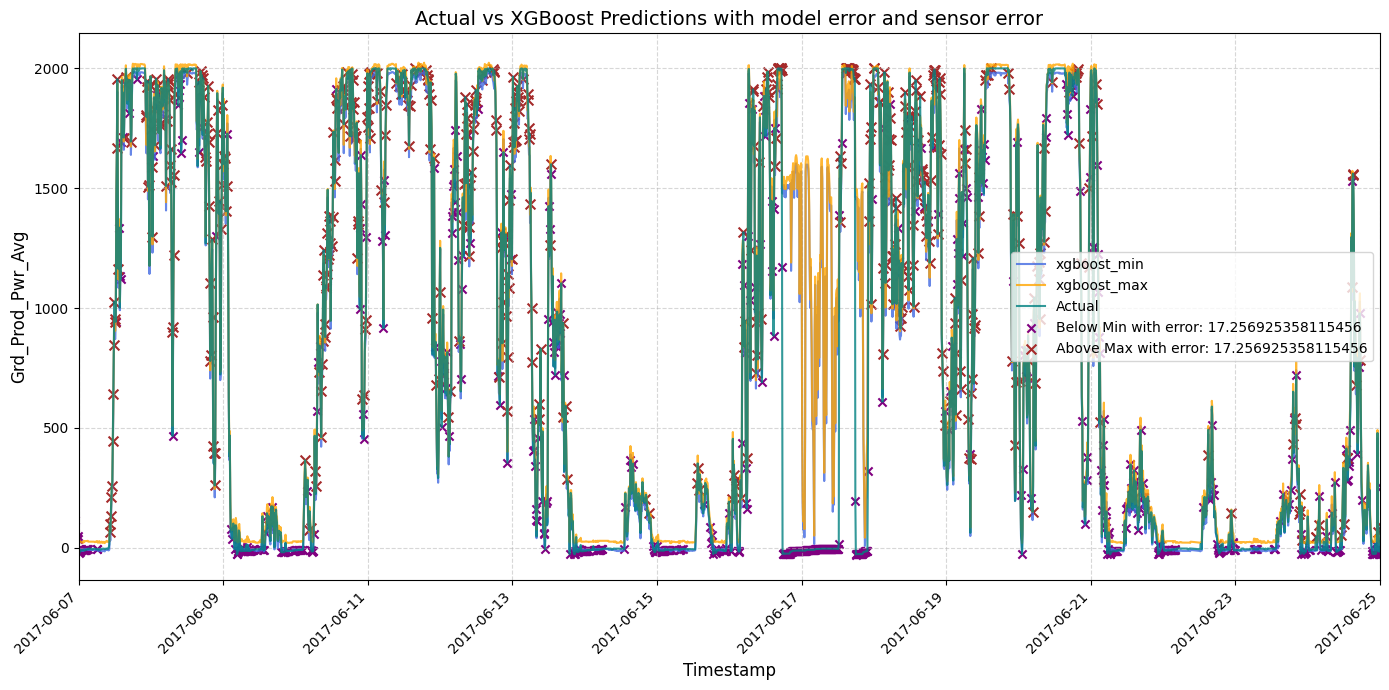

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define min and max bounds using xgboost predictions
merged_df_filtered17_sorted["xgboost_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - modelling_error_xgboost
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + modelling_error_xgboost

# Here we cap the maximum to be 2050


# Identify where actual values exceed bounds
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["xgboost_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["xgboost_max"]).astype(int)

# Start plotting
plt.figure(figsize=(14, 7))

# Plot min and max bounds
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_min"],
    color='royalblue', alpha=0.8, label='xgboost_min', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_max"],
    color='orange', alpha=0.8, label='xgboost_max', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below xgboost_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Below Min with error: {modelling_error_xgboost}'
)

# Scatter points where actual is above xgboost_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max with error: {modelling_error_xgboost}'
)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))
plt.title("Actual vs XGBoost Predictions with model error and sensor error", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


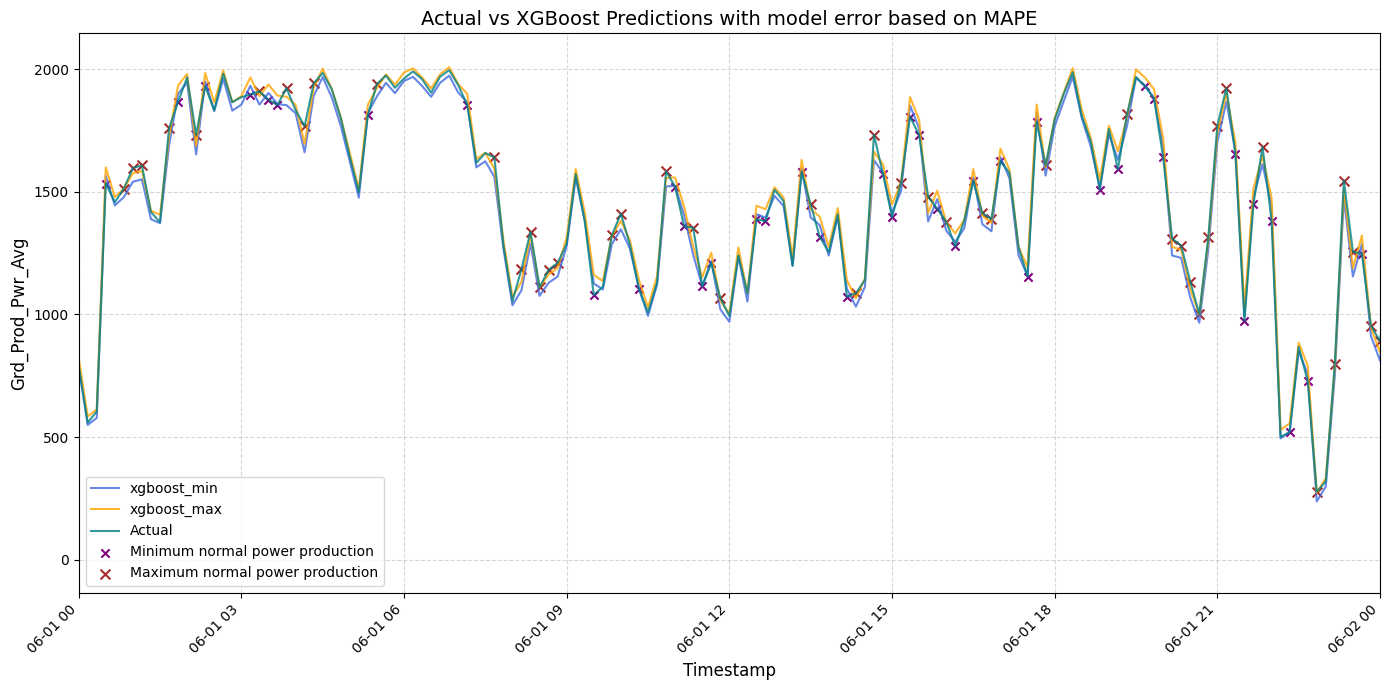

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define min and max bounds using xgboost predictions
merged_df_filtered17_sorted["xgboost_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - modelling_error_xgboost
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + modelling_error_xgboost


# Identify where actual values exceed bounds
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["xgboost_min"])
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["xgboost_max"])

# Start plotting
plt.figure(figsize=(14, 7))

# Plot min and max bounds
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_min"],
    color='royalblue', alpha=0.8, label='xgboost_min', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_max"],
    color='orange', alpha=0.8, label='xgboost_max', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], target_column],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], target_column],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)


# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-01'), pd.to_datetime('2017-06-02'))
plt.title("Actual vs XGBoost Predictions with model error based on MAPE", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


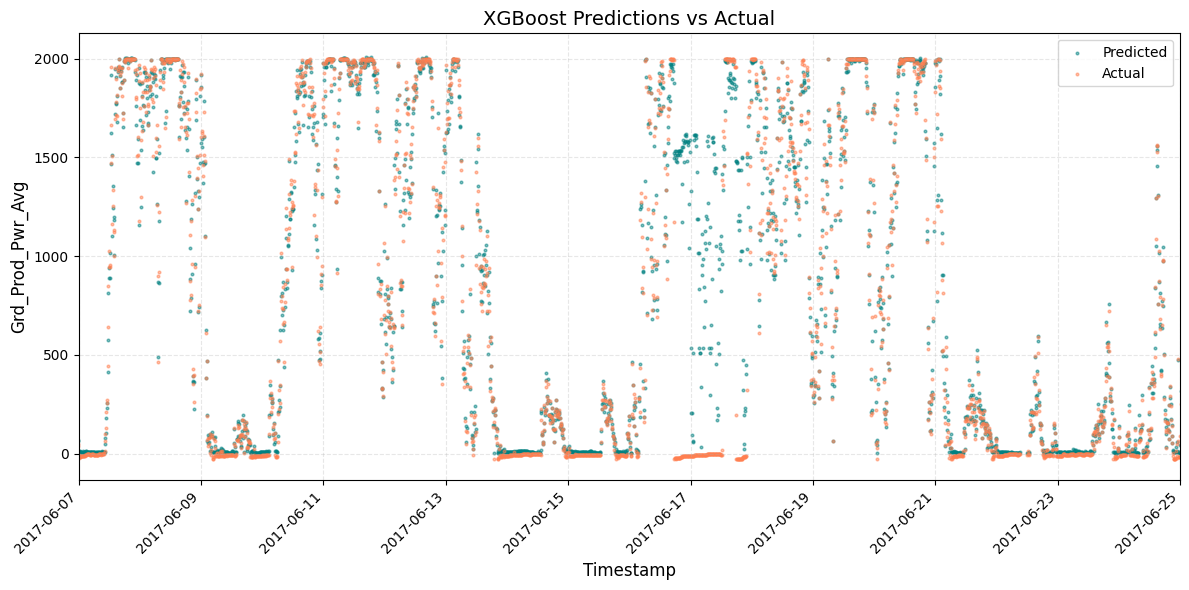

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    c='teal', alpha=0.5, label='Predicted', marker='.', s=15  # Adjusted size and transparency
)

# Scatter plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='coral', alpha=0.5, label='Actual', marker='.', s=15  # Different marker and transparency
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


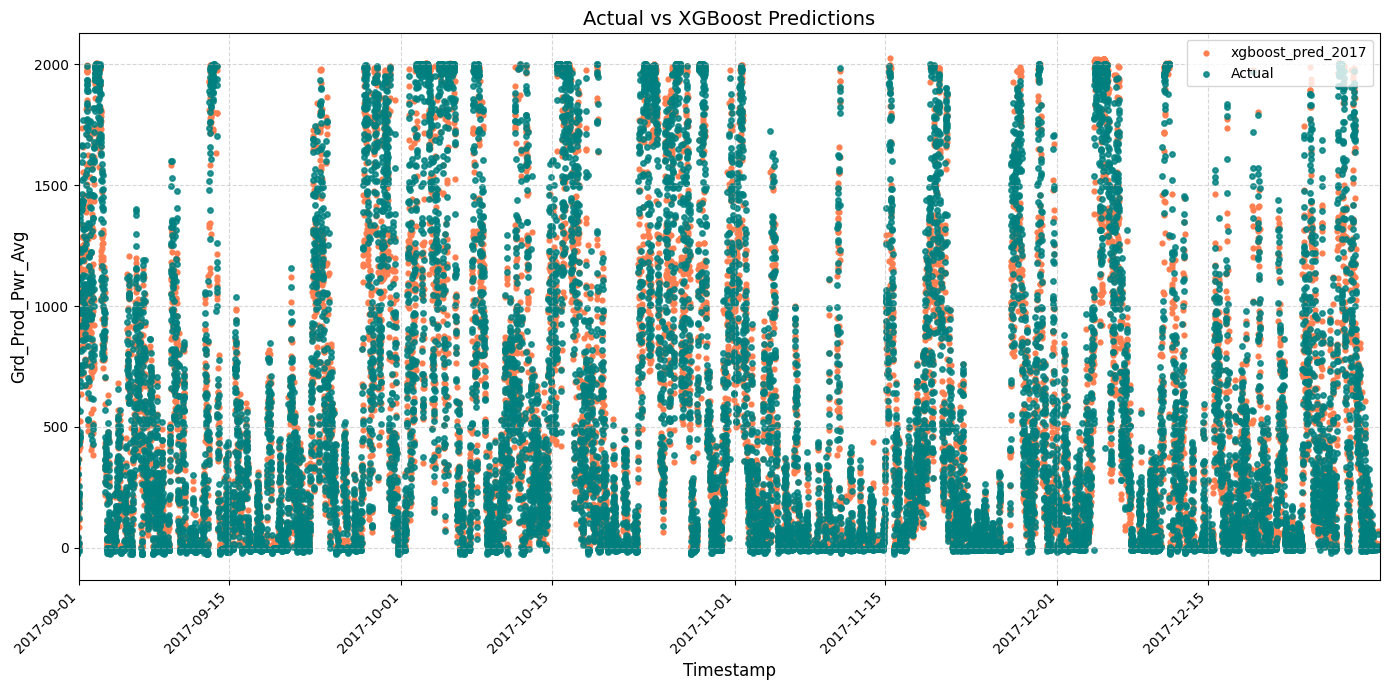

In [30]:
# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Start plotting
plt.figure(figsize=(14, 7))

# Scatter plot for xgboost predictions
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_pred_2017"],
    color='coral', marker='o', s=12, label='xgboost_pred_2017'
)

# Line plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, s=12,label='Actual', linestyle='-', linewidth=1.5
)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-09-01'), pd.to_datetime('2017-12-31'))
plt.title("Actual vs XGBoost Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

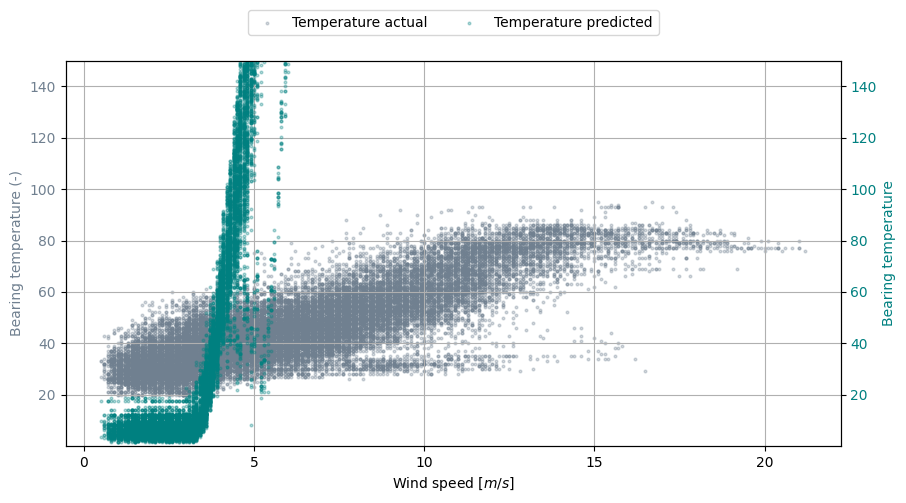

In [31]:
# Adjusted color scheme with burgundy and muted green
fig, ax1 = plt.subplots()  # Create a figure and axis

# Plotting the actual Cp values on the primary y-axis with burgundy
ax1.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], color='slategrey', label='Temperature actual', alpha=0.3, marker='.', s=15)
ax1.set_xlabel('Wind speed [$m/s$]')  # x-axis label
ax1.set_ylabel('Bearing temperature (-)', color='slategrey')  # Primary y-axis label color
ax1.tick_params(axis='y', labelcolor='slategrey')  # Primary y-axis label tick color
ax1.grid()
ax1.set_ylim(0.1, 150)  # Set y-limits for Cp values

# Create a secondary y-axis with a muted green color
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["xgboost_pred_2017"], color='teal', label='Temperature predicted', alpha=0.3, marker='.', s=15)  # Muted olive green color
ax2.set_ylabel('Bearing temperature', color='teal')  # Secondary y-axis label color
ax2.tick_params(axis='y', labelcolor='teal')  # Secondary y-axis label tick color
ax2.set_ylim(0.1, 150)

# Optional: Add legends for both y-axes with subtle colors
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=ax1.transAxes, ncol=2)

# Show the plot
plt.show()

# Intervals:

## Interval air density combinations

In [32]:
"""import pandas as pd
import numpy as np
import itertools

# Define intervals for the specific features
Humidity_interval = [-0.5, 0.5]       # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]          # hPa (for Avg_Pressure)
Amb_Temp_interval = [-2, 2]          # Celsius (for Amb_Temp_Avg)

# Generate all combinations of interval adjustments
combinations_airdensity = list(itertools.product(
    Humidity_interval,
    Pressure_interval,
    Amb_Temp_interval
))

# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  # Dry air
R_v = 461.495  # Water vapor

# Iterate through the combinations
for idx, combo in enumerate(combinations_airdensity):
    Humidity_val, Pressure_val, Temp_val = combo
    
    # Apply interval adjustments to create new columns for each combination
    merged_df_filtered17_sorted[f'Avg_Humidity_{idx+1}'] = merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val
    merged_df_filtered17_sorted[f'Avg_Pressure_{idx+1}'] = merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
    merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}'] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + Temp_val
    
    # Convert temperature to Kelvin and pressure to Pascals
    T = merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}'] + 273.15  # Kelvin
    p = merged_df_filtered17_sorted[f'Avg_Pressure_{idx+1}'] * 100      # Pa
    
    # Calculate saturation vapor pressure (Pa) using the Magnus formula
    e_s = 6.112 * np.exp((17.67 * merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}']) / 
                          (merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}'] + 243.5)) * 100
    
    # Convert relative humidity to a fraction
    RH_frac = merged_df_filtered17_sorted[f'Avg_Humidity_{idx+1}'] / 100.0
    
    # Calculate the actual water vapor pressure (Pa)
    p_v = RH_frac * e_s
    
    # Calculate the partial pressure of dry air (Pa)
    p_d = p - p_v
    
    # Compute air density (kg/m^3)
    merged_df_filtered17_sorted[f'airdensity_{idx+1}'] = (p_d / (R_d * T)) + (p_v / (R_v * T))
    
    # Print sample values for debugging
    print(f"\nCombination {idx+1}:")
    print("Avg_Humidity sample values:", merged_df_filtered17_sorted[f'Avg_Humidity_{idx+1}'].head(3).values)
    print("Avg_Pressure sample values:", merged_df_filtered17_sorted[f'Avg_Pressure_{idx+1}'].head(3).values)
    print("Amb_Temp_Avg sample values:", merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}'].head(3).values)
    print("Calculated air density sample values:", merged_df_filtered17_sorted[f'airdensity_{idx+1}'].head(3).values)

# Optionally, save or visualize the modified DataFrame
# merged_df_filtered17_sorted.to_csv('airdensity_predictions.csv', index=False)
"""

'import pandas as pd\nimport numpy as np\nimport itertools\n\n# Define intervals for the specific features\nHumidity_interval = [-0.5, 0.5]       # percentage (for Avg_Humidity)\nPressure_interval = [-1, 1]          # hPa (for Avg_Pressure)\nAmb_Temp_interval = [-2, 2]          # Celsius (for Amb_Temp_Avg)\n\n# Generate all combinations of interval adjustments\ncombinations_airdensity = list(itertools.product(\n    Humidity_interval,\n    Pressure_interval,\n    Amb_Temp_interval\n))\n\n# Define gas constants for dry air and water vapor in J/(kg*K)\nR_d = 287.058  # Dry air\nR_v = 461.495  # Water vapor\n\n# Iterate through the combinations\nfor idx, combo in enumerate(combinations_airdensity):\n    Humidity_val, Pressure_val, Temp_val = combo\n    \n    # Apply interval adjustments to create new columns for each combination\n    merged_df_filtered17_sorted[f\'Avg_Humidity_{idx+1}\'] = merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val\n    merged_df_filtered17_sorted[f\'Avg_Pr

## Model for making air density with interval analysis
Inputs humidity, pressure and temp. Outputs all 8 combinations of air density for that timestep

In [33]:
# Define intervals for each feature
Amb_Temp_interval = [-2, 2]         # degrees (for Amb_Temp_Avg)
Gen_RPM_interval = [-1, 1]          # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-1, 1]        # m/s (for Amb_WindSpeed_Avg)
Humidity_interval = [-0.5, 0.5]     # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]         # hPa? (for Avg_Pressure)





In [34]:
"""
airdensity_interval = [max(merged_df_filtered17_sorted["air_density_interval"]), min(merged_df_filtered17_sorted["air_density_interval"])]
"""

'\nairdensity_interval = [max(merged_df_filtered17_sorted["air_density_interval"]), min(merged_df_filtered17_sorted["air_density_interval"])]\n'

In [35]:
"""# Calculate maximum values by adding the max of each interval to the average values
merged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density"] + max(airdensity_interval)

# Calculate minimum values by adding the min of each interval to the average values
merged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density"] - min(airdensity_interval)"""

'# Calculate maximum values by adding the max of each interval to the average values\nmerged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density"] + max(airdensity_interval)\n\n# Calculate minimum values by adding the min of each interval to the average values\nmerged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density"] - min(airdensity_interval)'

In [36]:
# Calculate maximum values by adding the max of each interval to the average values
##merged_df_filtered17_sorted["max_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + max(Amb_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)
#merged_df_filtered17_sorted["max_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(Humidity_interval)
#merged_df_filtered17_sorted["max_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] + max(Pressure_interval)


# Calculate minimum values by adding the min of each interval to the average values
#merged_df_filtered17_sorted["min_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] - min(Amb_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] - min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] - min(Windspeed_interval)
#merged_df_filtered17_sorted["min_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] - min(Humidity_interval)
#merged_df_filtered17_sorted["min_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] - min(Pressure_interval)

In [ ]:
"""# Calculate maximum values by adding the max of each interval to the base air density
merged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density"] + max(air_density_interval)

# Calculate minimum values by adding the min of each interval to the base air density
merged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density"] - min(air_density_interval)
"""

KeyError: 'air_density'

In [38]:
"""import pandas as pd
import numpy as np
import itertools

# Define intervals for the specific features
Humidity_interval = [-0.5, 0.5]       # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]          # hPa (for Avg_Pressure)
Amb_Temp_interval = [-2, 2]          # Celsius (for Amb_Temp_Avg)

# Generate all combinations of interval adjustments
combinations_airdensity = list(itertools.product(
    Humidity_interval,
    Pressure_interval,
    Amb_Temp_interval
))

# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  # Dry air
R_v = 461.495  # Water vapor

# Create a column to store air density values for each timestep as a list
merged_df_filtered17_sorted["air_density_interval"] = [[] for _ in range(len(merged_df_filtered17_sorted))]

# Iterate through the combinations
for idx, (Humidity_val, Pressure_val, Temp_val) in enumerate(combinations_airdensity):
    
    # Apply interval adjustments
    adj_humidity = merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val
    adj_pressure = merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
    adj_temp = merged_df_filtered17_sorted["Amb_Temp_Avg"] + Temp_val

    # Convert temperature to Kelvin and pressure to Pascals
    T = adj_temp + 273.15  # Kelvin
    p = adj_pressure * 100  # Pa

    # Calculate saturation vapor pressure (Pa) using the Magnus formula
    e_s = 6.112 * np.exp((17.67 * adj_temp) / (adj_temp + 243.5)) * 100

    # Convert relative humidity to a fraction
    RH_frac = adj_humidity / 100.0

    # Calculate the actual water vapor pressure (Pa)
    p_v = RH_frac * e_s

    # Calculate the partial pressure of dry air (Pa)
    p_d = p - p_v

    # Compute air density (kg/m^3)
    air_density = (p_d / (R_d * T)) + (p_v / (R_v * T))

    # Store in DataFrame
    merged_df_filtered17_sorted[f'airdensity_{idx+1}'] = air_density
    merged_df_filtered17_sorted["air_density_interval"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: list(x) + [air_density.tolist()])

# Compute max and min air density
merged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: max(np.concatenate(x)))
merged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: min(np.concatenate(x)))
"""

'import pandas as pd\nimport numpy as np\nimport itertools\n\n# Define intervals for the specific features\nHumidity_interval = [-0.5, 0.5]       # percentage (for Avg_Humidity)\nPressure_interval = [-1, 1]          # hPa (for Avg_Pressure)\nAmb_Temp_interval = [-2, 2]          # Celsius (for Amb_Temp_Avg)\n\n# Generate all combinations of interval adjustments\ncombinations_airdensity = list(itertools.product(\n    Humidity_interval,\n    Pressure_interval,\n    Amb_Temp_interval\n))\n\n# Define gas constants for dry air and water vapor in J/(kg*K)\nR_d = 287.058  # Dry air\nR_v = 461.495  # Water vapor\n\n# Create a column to store air density values for each timestep as a list\nmerged_df_filtered17_sorted["air_density_interval"] = [[] for _ in range(len(merged_df_filtered17_sorted))]\n\n# Iterate through the combinations\nfor idx, (Humidity_val, Pressure_val, Temp_val) in enumerate(combinations_airdensity):\n    \n    # Apply interval adjustments\n    adj_humidity = merged_df_filtere

In [76]:
import pandas as pd
import numpy as np
import itertools

# Define intervals for the specific features
Humidity_interval = [-0.3, 0.3]       # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]          # hPa (for Avg_Pressure)
Amb_Temp_interval = [-1, 1]          # Celsius (for Amb_Temp_Avg)

# Generate all combinations of interval adjustments
combinations_airdensity = list(itertools.product(
    Humidity_interval,
    Pressure_interval,
    Amb_Temp_interval
))

# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  # Dry air
R_v = 461.495  # Water vapor

# Initialize a dictionary to store air density values for each timestep
air_density_values = {idx: [] for idx in range(len(merged_df_filtered17_sorted))}

# Iterate through the combinations
for Humidity_val, Pressure_val, Temp_val in combinations_airdensity:
    
    # Apply interval adjustments
    adj_humidity = merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val
    adj_pressure = merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
    adj_temp = merged_df_filtered17_sorted["Amb_Temp_Avg"] + Temp_val

    # Convert temperature to Kelvin and pressure to Pascals
    T = adj_temp + 273.15  # Kelvin
    p = adj_pressure * 100  # Pa

    # Calculate saturation vapor pressure (Pa) using the Magnus formula
    e_s = 6.112 * np.exp((17.67 * adj_temp) / (adj_temp + 243.5)) * 100

    # Convert relative humidity to a fraction
    RH_frac = adj_humidity / 100.0

    # Calculate the actual water vapor pressure (Pa)
    p_v = RH_frac * e_s

    # Calculate the partial pressure of dry air (Pa)
    p_d = p - p_v

    # Compute air density (kg/m^3)
    air_density = (p_d / (R_d * T)) + (p_v / (R_v * T))

    # Store air density values in the dictionary
    for idx, value in enumerate(air_density):
        air_density_values[idx].append(value)

# Ensure values are lists before assignment
merged_df_filtered17_sorted["air_density_interval"] = merged_df_filtered17_sorted.index.map(lambda x: air_density_values.get(x, []))

# Compute max and min air density safely
merged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: max(x) if x else np.nan)
merged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: min(x) if x else np.nan)


In [77]:
"""import itertools
import pandas as pd
import numpy as np

# Define additional feature intervals
Gen_RPM_interval = [-50, 50]         # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-1, 1]         # m/s (for Amb_WindSpeed_Avg)

# Generate all 8 combinations of max/min values
combinations = list(itertools.product(["max", "min"], ["max", "min"], ["max", "min"]))

# Compute max/min for Wind Speed and Generator RPM
merged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)
merged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + min(Windspeed_interval)

# Iterate through all 8 combinations
for idx, (air_density_key, wind_speed_key, rpm_key) in enumerate(combinations):
    
    # Ensure correct column names for air density
    air_density_col = f"{air_density_key}_air_density"
    
    if air_density_col not in merged_df_filtered17_sorted.columns:
        print(f"Warning: {air_density_col} not found in DataFrame. Skipping combination {idx+1}.")
        continue

    # Create X_test for each combination
    X_test = pd.DataFrame({
        'Gen_RPM_Avg': merged_df_filtered17_sorted[f"{rpm_key}_Gen_RPM_Avg"],
        'Amb_WindSpeed_Avg': merged_df_filtered17_sorted[f"{wind_speed_key}_Amb_WindSpeed_Avg"],
        "air_density": merged_df_filtered17_sorted[air_density_col]
    })

    # Handle potential NaN values before prediction
    X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values

    # Predict power output
    predictions = model.predict(X_test)

    # Store results
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions
    print(f"Combination {idx+1} done: air_density={air_density_key}, wind_speed={wind_speed_key}, rpm={rpm_key}")
"""

'import itertools\nimport pandas as pd\nimport numpy as np\n\n# Define additional feature intervals\nGen_RPM_interval = [-50, 50]         # RPM (for Gen_RPM_Avg)\nWindspeed_interval = [-1, 1]         # m/s (for Amb_WindSpeed_Avg)\n\n# Generate all 8 combinations of max/min values\ncombinations = list(itertools.product(["max", "min"], ["max", "min"], ["max", "min"]))\n\n# Compute max/min for Wind Speed and Generator RPM\nmerged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)\nmerged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)\nmerged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)\nmerged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + min(Windspeed_interval)\n\n# Iterate through all 8 combinations\nfor idx, (air_density_key, wind_speed_ke

In [78]:
import itertools
import pandas as pd
import numpy as np

# Create X_test ensuring column order matches model training
X_test = merged_df_filtered17_sorted[[ "airdensity", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]]

# Define additional feature intervals
Gen_RPM_interval = [-2, 2]         # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-0.3, 0.3]         # m/s (for Amb_WindSpeed_Avg)

# Generate all 8 combinations of max/min values
combinations = list(itertools.product(["max", "min"], ["max", "min"], ["max", "min"]))

# Compute max/min for Wind Speed and Generator RPM
merged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)
merged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + min(Windspeed_interval)

# Iterate through all 8 combinations
for idx, (air_density_key, wind_speed_key, rpm_key) in enumerate(combinations):
    
    # Ensure correct column names for air density
    air_density_col = f"{air_density_key}_air_density"
    
    if air_density_col not in merged_df_filtered17_sorted.columns:
        print(f"Warning: {air_density_col} not found in DataFrame. Skipping combination {idx+1}.")
        continue

    # Create X_test for each combination (ensuring column names match model)
    X_test = pd.DataFrame({
        "airdensity": merged_df_filtered17_sorted[air_density_col],
        'Gen_RPM_Avg': merged_df_filtered17_sorted[f"{rpm_key}_Gen_RPM_Avg"],
        'Amb_WindSpeed_Avg': merged_df_filtered17_sorted[f"{wind_speed_key}_Amb_WindSpeed_Avg"]
        
    })

    # Handle potential NaN values before prediction
    X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values

    # Predict power output using the trained model
    predictions = model.predict(X_test)

    # Store results in DataFrame
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions
    print(f"Combination {idx+1} done: air_density={air_density_key}, wind_speed={wind_speed_key}, rpm={rpm_key}")


Combination 1 done: air_density=max, wind_speed=max, rpm=max
Combination 2 done: air_density=max, wind_speed=max, rpm=min
Combination 3 done: air_density=max, wind_speed=min, rpm=max
Combination 4 done: air_density=max, wind_speed=min, rpm=min
Combination 5 done: air_density=min, wind_speed=max, rpm=max
Combination 6 done: air_density=min, wind_speed=max, rpm=min
Combination 7 done: air_density=min, wind_speed=min, rpm=max
Combination 8 done: air_density=min, wind_speed=min, rpm=min


C:\Users\thors\AppData\Local\Temp\ipykernel_9508\3531696615.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values
C:\Users\thors\AppData\Local\Temp\ipykernel_9508\3531696615.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values
C:\Users\thors\AppData\Local\Temp\ipykernel_9508\3531696615.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values
C:\Users\thors\AppData\Local\Temp\ipykernel_9508\3531696615.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.f

In [79]:
print(model.get_booster().feature_names)

['airdensity', 'Gen_RPM_Avg', 'Amb_WindSpeed_Avg']


In [80]:
# Define min/max column names
min_columns = ["min_air_density", "min_Gen_RPM_Avg", "min_Amb_WindSpeed_Avg"]
max_columns = ["max_air_density", "max_Gen_RPM_Avg", "max_Amb_WindSpeed_Avg"]


# Generate all 32 combinations of 'min' and 'max' features
combinations = []
for i in range(32):
    combination = [max_columns[j] if (i >> j) & 1 else min_columns[j] for j in range(5)]
    combinations.append(combination)


# Ensure correct feature order for predictions
feature_columns = ["air_density","Gen_RPM_Avg", "Amb_WindSpeed_Avg"]

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    try:
        # Prepare feature set for the current combination
        combination_features = merged_df_filtered17_sorted[comb].copy()

        # Rename columns to match model feature order
        combination_features.columns = feature_columns

        # Ensure proper column order
        combination_features = combination_features[feature_columns]

        # Generate predictions
        predictions = model.predict(combination_features)

        # Add predictions to DataFrame
        merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions

    except KeyError as e:
        print(f"KeyError in combination {idx}: {e}. Skipping this combination.")
    except Exception as e:
        print(f"Unexpected error in combination {idx}: {e}")


# Print first few rows to verify
print(merged_df_filtered17_sorted.head())


IndexError: list index out of range

In [81]:

print(merged_df_filtered17_sorted.iloc[0])


Turbine_ID                                 T07
Timestamp            2017-01-01 00:00:00+00:00
Gen_RPM_Max                             1513.4
Gen_RPM_Min                             1255.3
Gen_RPM_Avg                             1336.5
                               ...            
above_max                                    0
diff_max_actual                     -19.870587
anomaly_isolation                            0
z_score                               0.303051
anomaly_z_score                              0
Name: 52211, Length: 150, dtype: object


In [82]:
Arotor

6362

## Only sensor error:

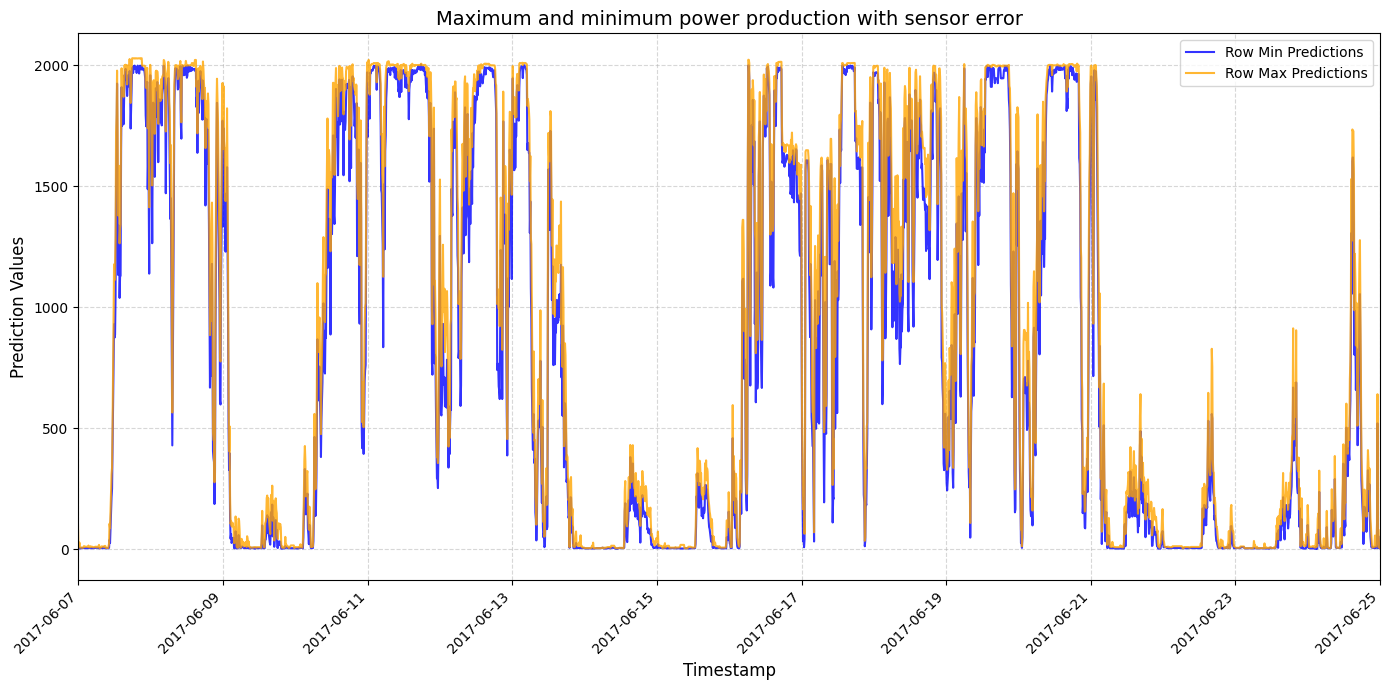

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot min and max predictions over time
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Maximum and minimum power production with sensor error", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Prediction Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


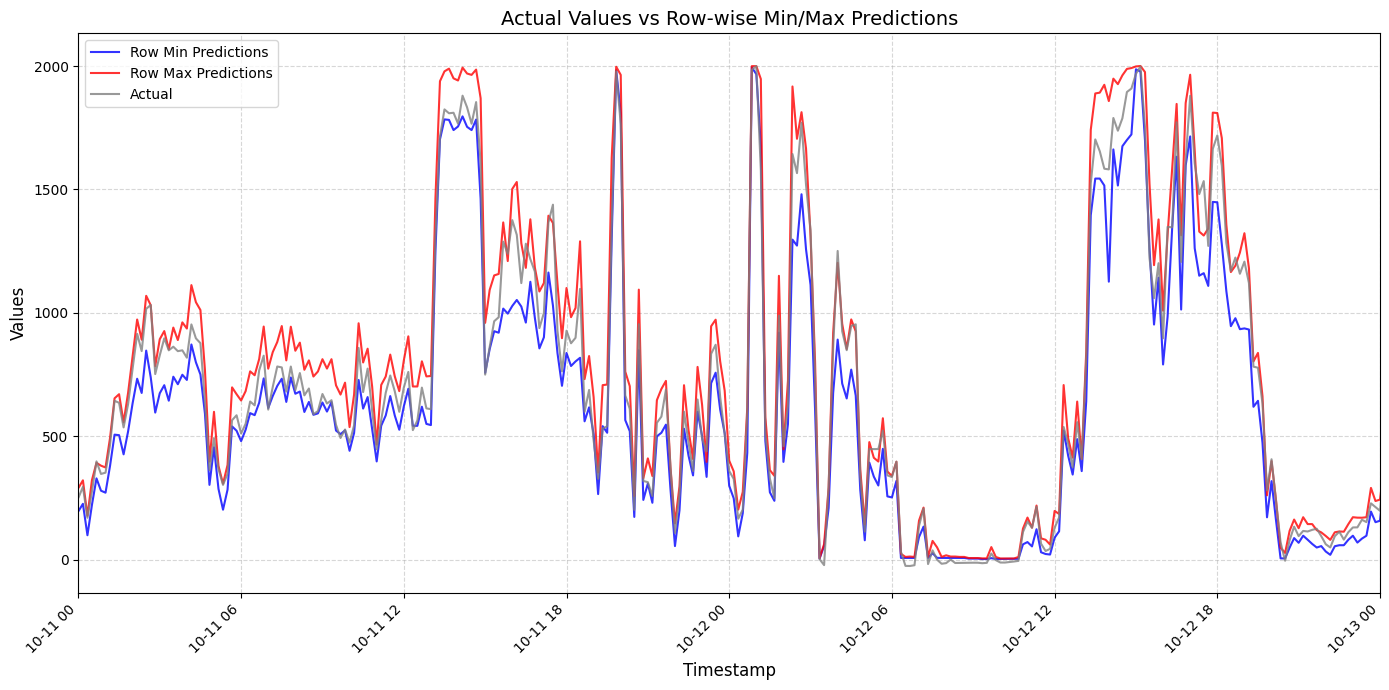

In [84]:


# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-10-11'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("Actual Values vs Row-wise Min/Max Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


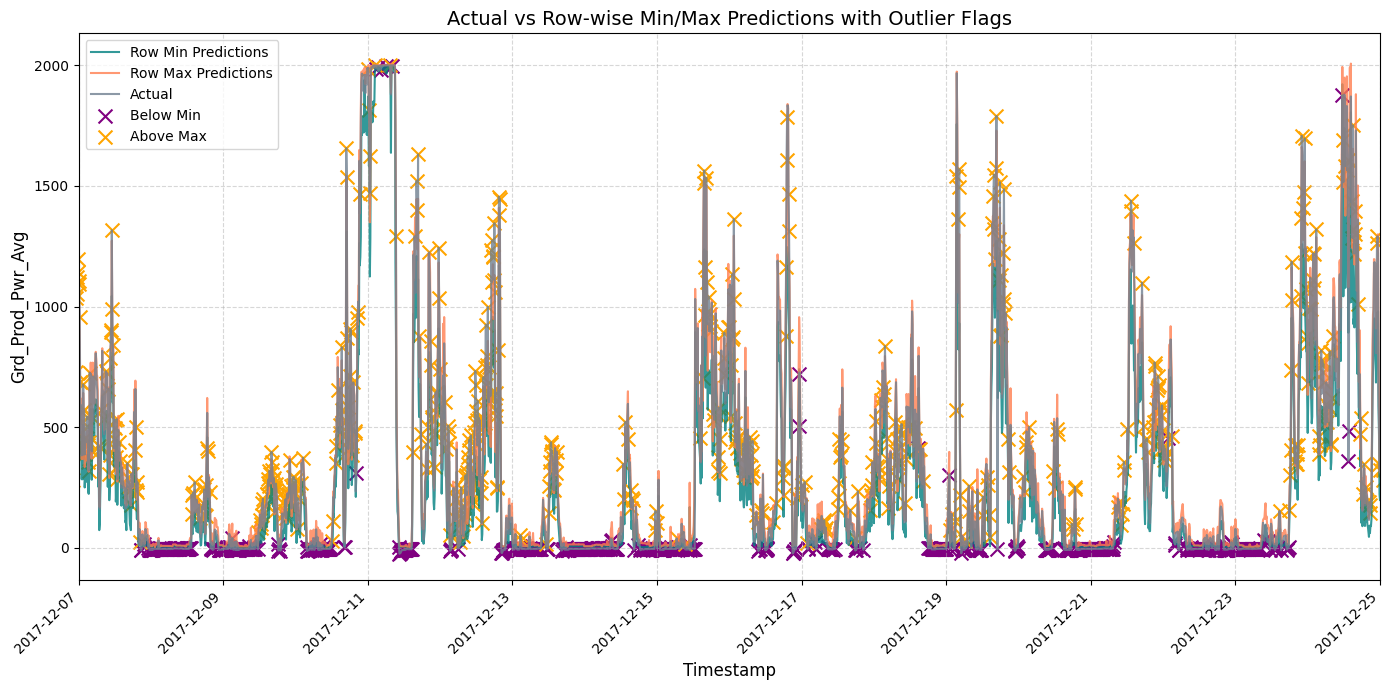

In [85]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)



# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]).astype(int)



# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='teal', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='coral', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='slategrey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label='Below Min'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label='Above Max'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Outlier Flags", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


## Adjust maximum power production here:

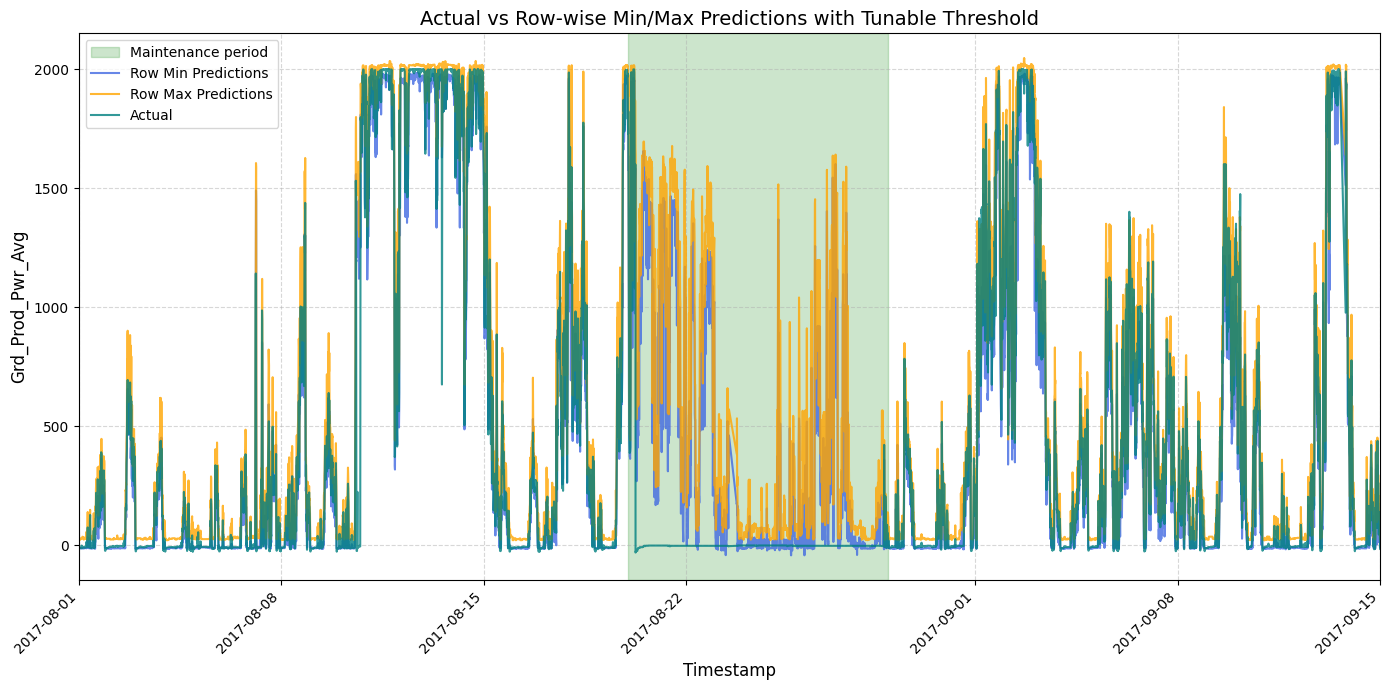

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

"""# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='coral', marker='x', s=50, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max + {threshold}'
)"""

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-08-01'), pd.to_datetime('2017-09-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


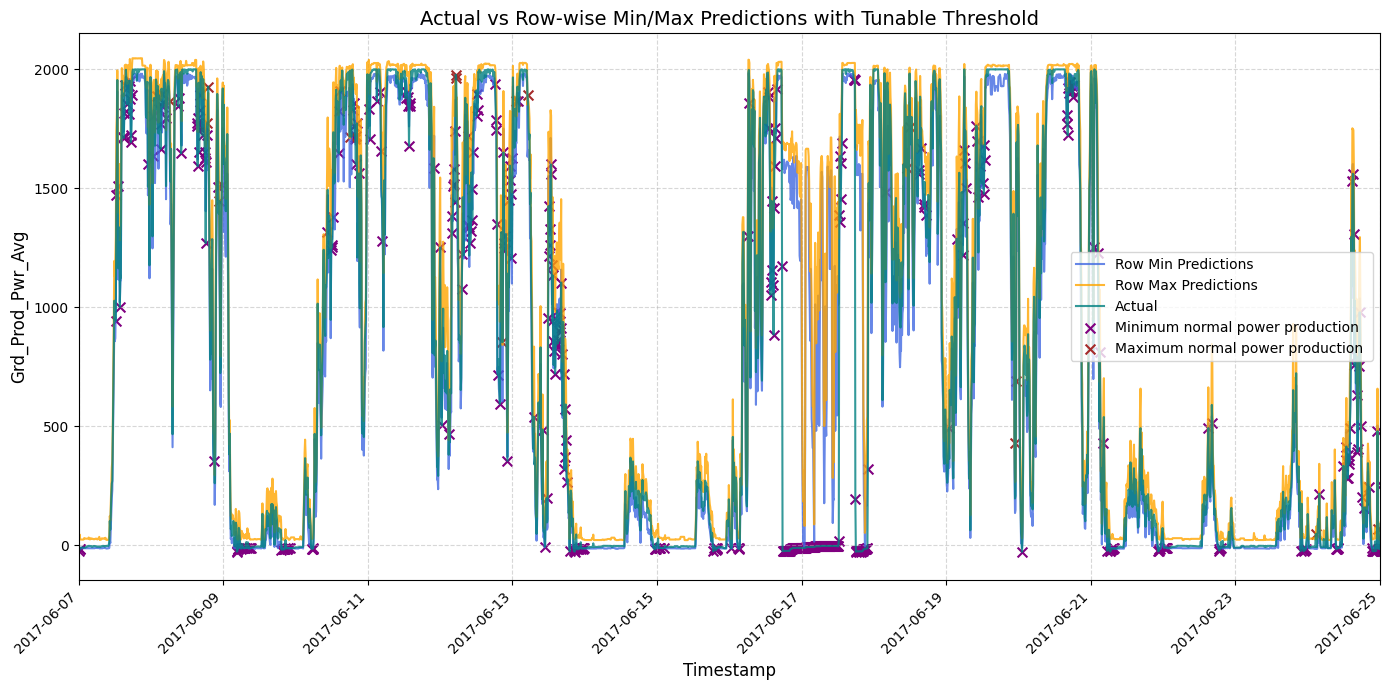

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")



# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)


# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=50, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production '
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


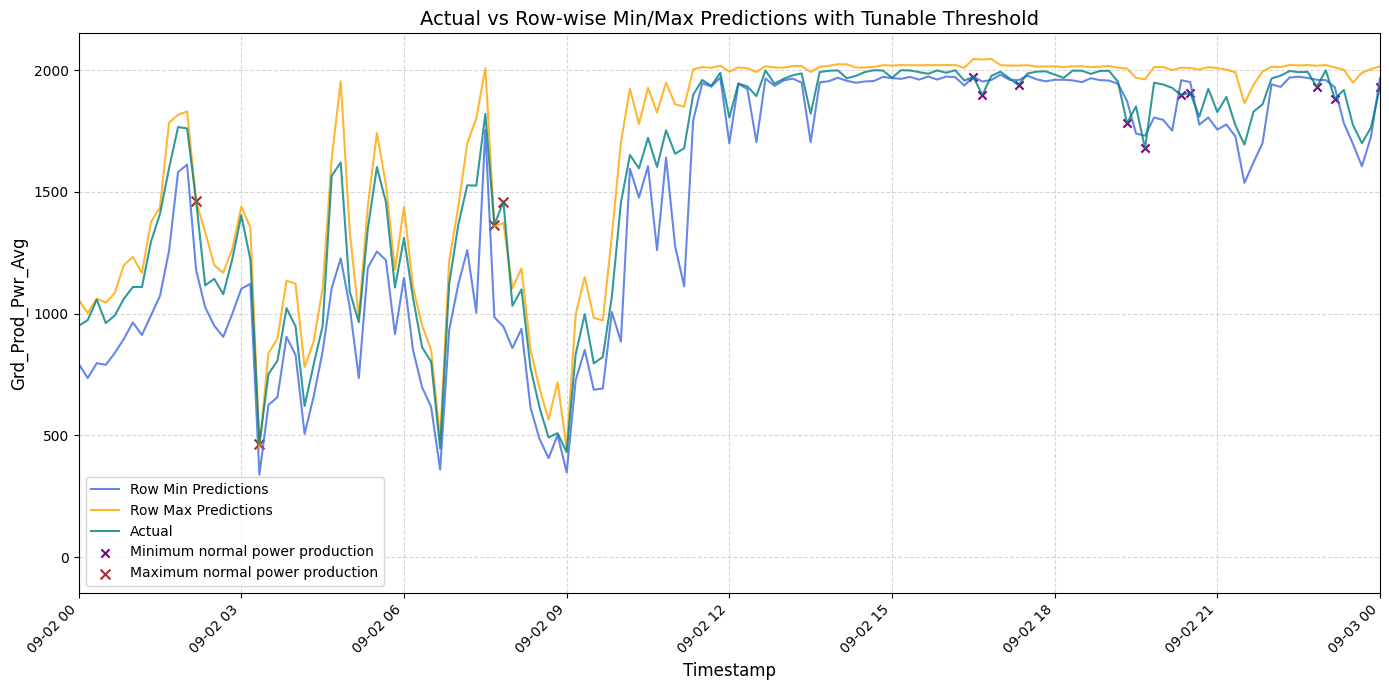

In [88]:
# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for sensor variational error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - (modelling_error_xgboost))
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + (modelling_error_xgboost))
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-09-02'), pd.to_datetime('2017-09-3'))


# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


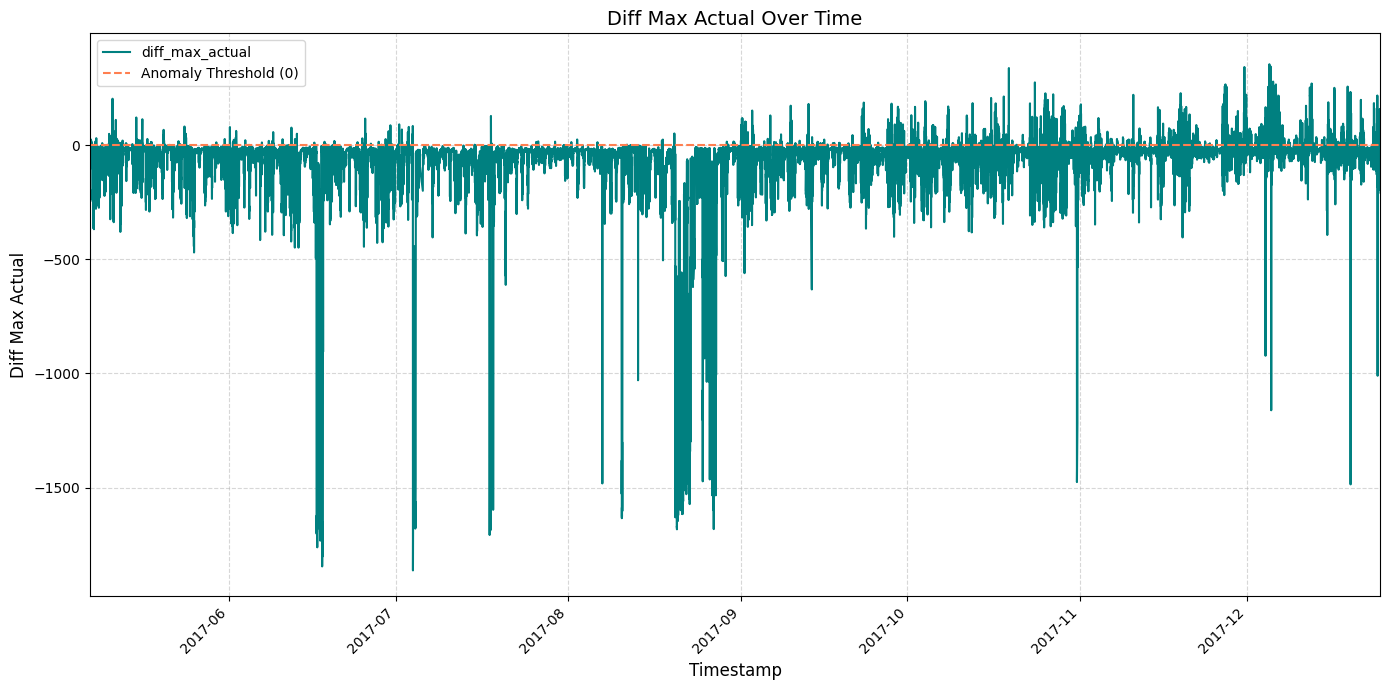

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

# === Visualization ===
plt.figure(figsize=(14, 7))

# Plot diff_max_actual with time
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["diff_max_actual"], 
    color='teal', label="diff_max_actual"
)

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Anomaly Threshold (0)")

# Configure plot
plt.title("Diff Max Actual Over Time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Diff Max Actual", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Apply x-axis limits
plt.xlim(pd.to_datetime('2017-05-07'), pd.to_datetime('2017-12-25'))

# Show plot
plt.show()


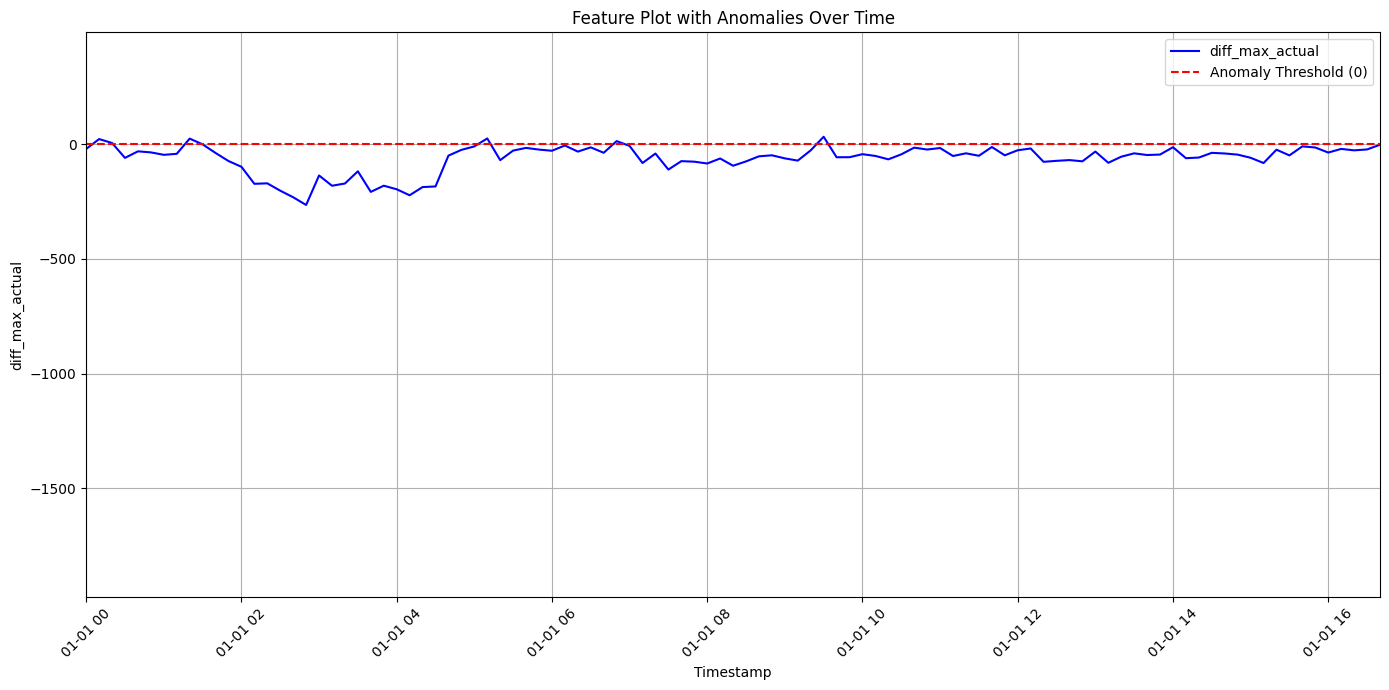

In [90]:
# Plot the feature with Timestamp on the x-axis and apply x-axis limits for better visibility
plt.figure(figsize=(14, 7))
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['diff_max_actual'], label='diff_max_actual', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Anomaly Threshold (0)')
plt.title('Feature Plot with Anomalies Over Time')
plt.xlabel('Timestamp')
plt.ylabel('diff_max_actual')
plt.legend()
plt.grid()

# Limiting the x-axis to show a specific portion of the data for clarity
plt.xlim(merged_df_filtered17_sorted['Timestamp'].iloc[0], 
         merged_df_filtered17_sorted['Timestamp'].iloc[100])  # Example: first 100 points
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [91]:
# Filter the data by date range
date_filtered_data = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= pd.to_datetime("2017-06-07").tz_localize("UTC")) &
    (merged_df_filtered17_sorted["Timestamp"] <= pd.to_datetime("2017-12-25").tz_localize("UTC"))
]
date_filtered_data.dropna(subset=["Gen_Bear_Temp_Avg", target_column, "Timestamp"])
# Use the smaller dataset for pairwise calculations
temperature_data = date_filtered_data["Gen_Bear_Temp_Avg"].values
actual = date_filtered_data["Gen_Bear_Temp_Avg"].values
predicted = date_filtered_data[target_column].values
timestamps = date_filtered_data["Timestamp"].values

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Combine actual and predicted into a single array for clustering
data_for_clustering = np.column_stack((predicted, actual))


# Remove rows with NaN values
data_for_clustering = data_for_clustering[~np.isnan(data_for_clustering).any(axis=1)]
# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust clusters if needed
date_filtered_data["Cluster"] = kmeans.fit_predict(data_for_clustering)

# Visualize clusters
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(kmeans.labels_):
    cluster_points = date_filtered_data[date_filtered_data["Cluster"] == cluster_id]
    plt.scatter(
        cluster_points[target_column],  # X: Predicted
        cluster_points["Gen_Bear_Temp_Avg"],  # Y: Actual
        label=f"Cluster {cluster_id}"
    )

plt.plot(predicted, predicted, color="red", linestyle="--", label="Prediction Reference Line")
plt.title("K-Means Clustering: Actual vs Predicted")
plt.xlabel("Predicted Temperature")
plt.ylabel("Actual Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Combine predicted and actual values into a DataFrame for cleaning
data_for_clustering = pd.DataFrame({
    "predicted": predicted,
    "actual": actual
})

# Drop rows with NaN values
data_for_clustering.dropna(inplace=True)

# Convert back to NumPy array
data_for_clustering = data_for_clustering.values

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(data_for_clustering)

# Assign cluster labels back to the original DataFrame
date_filtered_data = date_filtered_data.iloc[:len(data_for_clustering)].copy()  # Adjust length to match cleaned data
date_filtered_data["DBSCAN_Cluster"] = dbscan.labels_

# Visualize DBSCAN clusters
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(dbscan.labels_):
    cluster_points = date_filtered_data[date_filtered_data["DBSCAN_Cluster"] == cluster_id]
    plt.scatter(
        cluster_points[target_column],  # X: Predicted
        cluster_points["Gen_Bear_Temp_Avg"],  # Y: Actual
        label=f"Cluster {cluster_id}" if cluster_id != -1 else "Outliers"
    )

plt.plot(predicted, predicted, color="red", linestyle="--", label="Prediction Reference Line")
plt.title("DBSCAN Clustering: Actual vs Predicted")
plt.xlabel("Predicted Temperature")
plt.ylabel("Actual Temperature")
plt.legend()
plt.grid()
plt.show()



In [ ]:
date_filtered_data['Rolling_Mean'] = date_filtered_data['Gen_Bear_Temp_Avg'].rolling(window=10).mean()
date_filtered_data['Rolling_Std'] = date_filtered_data['Gen_Bear_Temp_Avg'].rolling(window=10).std()
date_filtered_data['Anomaly'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - date_filtered_data['Rolling_Mean']) > 2 * date_filtered_data['Rolling_Std']


In [ ]:
from scipy.stats import zscore
date_filtered_data['Z_Score'] = zscore(date_filtered_data['Gen_Bear_Temp_Avg'])
date_filtered_data['Anomaly_Z_Score'] = abs(date_filtered_data['Z_Score']) > 2


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Z_Score']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Z_Score']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Z-Score")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.02)  # Adjust contamination rate as needed
date_filtered_data['Anomaly_IF'] = iso_forest.fit_predict(data_for_clustering)

# Convert -1 (anomalous) and 1 (normal) to boolean for easy filtering
date_filtered_data['Anomaly_IF'] = date_filtered_data['Anomaly_IF'] == -1


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_IF']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_IF']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Isolation Forest")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


Additional isolation forrest

In [ ]:
"""# Check for duplicate timestamps
if 'Turbine_ID' in date_filtered_data.columns:
    date_filtered_data.drop(columns=['Turbine_ID'], inplace=True)

# Drop duplicate timestamps, keeping the first occurrence
date_filtered_data = date_filtered_data[~date_filtered_data.index.duplicated(keep='first')]

# Alternatively, aggregate duplicate timestamps by averaging
date_filtered_data = date_filtered_data.groupby(date_filtered_data.index).mean()

"""



In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Reset index to ensure 'Timestamp' is available as a column
date_filtered_data.reset_index(inplace=True)

# Remove timezone information from the Timestamp column if any
date_filtered_data['Timestamp'] = date_filtered_data['Timestamp'].dt.tz_localize(None)

# Prepare the data for Prophet (ensure 'Timestamp' is now a column)
df_prophet = date_filtered_data[['Timestamp', 'Gen_Bear_Temp_Avg']].rename(columns={'Timestamp': 'ds', 'Gen_Bear_Temp_Avg': 'y'})

# Ensure the datetime column 'ds' has a proper frequency (set frequency to daily 'D')
df_prophet = df_prophet.set_index('ds').asfreq('D').reset_index()

# Fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Make future predictions (here we are just forecasting for the historical data)
future = model.make_future_dataframe(df_prophet, freq='D')
forecast = model.predict(future)

# Detect anomalies where actual values deviate significantly from the forecast
date_filtered_data['Anomaly_Prophet'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - forecast['yhat']) > 2 * (forecast['yhat_upper'] - forecast['yhat_lower'])

# Plot the actual data and forecast with anomalies
plt.figure(figsize=(14, 7))

# Plot the actual temperature
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], color='grey', alpha=0.8, label='Actual', linewidth=1.5)

# Plot the forecasted temperature (mean, upper, and lower bounds)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', color='blue', linewidth=1.5)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight anomalies (where actual temperature deviates significantly from forecast)
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies", s=80)

# Customize the plot
plt.title("Actual vs Forecasted Temperature with Anomalies Detected", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import STL

# Ensure the Timestamp column is in datetime format
date_filtered_data['Timestamp'] = pd.to_datetime(date_filtered_data['Timestamp'])

# Set the frequency of the time series (daily in this case)
date_filtered_data.set_index('Timestamp', inplace=True)
date_filtered_data = date_filtered_data.asfreq('D')  # Set frequency to daily (change if needed)

# Perform STL decomposition
stl = STL(date_filtered_data['Gen_Bear_Temp_Avg'], seasonal=13)
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

# Use the residuals to detect anomalies
residuals = result.resid
date_filtered_data['Anomaly_STL'] = abs(residuals) > 2 * residuals.std()

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data.index, date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data.index[date_filtered_data['Anomaly_STL']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_STL']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using STL Decomposition")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Reset index to ensure 'Timestamp' is available as a column
date_filtered_data.reset_index(inplace=True)

# Remove timezone information from the Timestamp column if any
date_filtered_data['Timestamp'] = date_filtered_data['Timestamp'].dt.tz_localize(None)

# Prepare the data for Prophet (ensure 'Timestamp' is now a column)
df_prophet = date_filtered_data[['Timestamp', 'Gen_Bear_Temp_Avg']].rename(columns={'Timestamp': 'ds', 'Gen_Bear_Temp_Avg': 'y'})

# Ensure the datetime column 'ds' has a proper frequency (set frequency to daily 'D')
df_prophet = df_prophet.set_index('ds').asfreq('D').reset_index()

# Fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Make future predictions (here we are just forecasting for the historical data)
future = model.make_future_dataframe(df_prophet, freq='D')
forecast = model.predict(future)

# Detect anomalies where actual values deviate significantly from the forecast
date_filtered_data['Anomaly_Prophet'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - forecast['yhat']) > 2 * (forecast['yhat_upper'] - forecast['yhat_lower'])

# Plot the actual data and forecast with anomalies
plt.figure(figsize=(14, 7))

# Plot the actual temperature
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], color='grey', alpha=0.8, label='Actual', linewidth=1.5)

# Plot the forecasted temperature (mean, upper, and lower bounds)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', color='blue', linewidth=1.5)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight anomalies (where actual temperature deviates significantly from forecast)
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies", s=80)

# Customize the plot
plt.title("Actual vs Forecasted Temperature with Anomalies Detected", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Prophet Model")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Drop rows with missing values in 'Gen_Bear_Temp_Avg'
merged_df_filtered17_sorted = merged_df_filtered17_sorted.dropna(subset=['Gen_Bear_Temp_Avg'])

# Now proceed with LOF model
from sklearn.neighbors import LocalOutlierFactor

# Define the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model and predict anomalies
X = merged_df_filtered17_sorted[['Gen_Bear_Temp_Avg']]  # Actual temperature data (or combine predicted and actual)
merged_df_filtered17_sorted['anomaly_lof'] = lof.fit_predict(X)
merged_df_filtered17_sorted['anomaly_lof'] = merged_df_filtered17_sorted['anomaly_lof'].apply(lambda x: 1 if x == -1 else 0)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by LOF
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_lof'] == 1]
plt.scatter(anomalies['Timestamp'], anomalies['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (LOF)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Local Outlier Factor (LOF)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Compute Z-scores for Gen_Bear_Temp_Avg
merged_df_filtered17_sorted['z_score'] = (merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'] - merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'].mean()) / merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'].std()

# Define a threshold for anomaly detection
z_threshold = 2.5  # Example threshold: 3 standard deviations

# Flag anomalies where Z-score is above or below the threshold
merged_df_filtered17_sorted['anomaly_zscore'] = (np.abs(merged_df_filtered17_sorted['z_score']) > z_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Z-score
anomalies_zscore = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_zscore'] == 1]
plt.scatter(anomalies_zscore['Timestamp'], anomalies_zscore['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Z-score)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Z-Score Method", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Ensure Timestamp is in datetime format
merged_df_filtered17_sorted['Timestamp'] = pd.to_datetime(merged_df_filtered17_sorted['Timestamp'])

# Filter the data between 2017-06-07 and 2017-06-25
start_date = '2017-06-07'
end_date = '2017-10-25'
filtered_data = merged_df_filtered17_sorted[(merged_df_filtered17_sorted['Timestamp'] >= start_date) & 
                                             (merged_df_filtered17_sorted['Timestamp'] <= end_date)]

# Define the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 32, 64), activation='relu', solver='adam', random_state=42)

# Use Gen_Bear_Temp_Avg as input and try to predict it
X = filtered_data[['Gen_Bear_Temp_Avg']].values
autoencoder.fit(X, X)  # Train the autoencoder

# Predict reconstructed values
reconstructed = autoencoder.predict(X)

# Calculate row-wise reconstruction error (Mean Squared Error for each sample)
reconstruction_error = np.mean((X - reconstructed) ** 2, axis=1)

# Define a threshold for reconstruction error (e.g., top 5% of reconstruction errors)
error_threshold = np.percentile(reconstruction_error, 99)  # top 5% errors are anomalies

# Flag anomalies based on reconstruction error
filtered_data['anomaly_autoencoder'] = (reconstruction_error > error_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(filtered_data['Timestamp'], filtered_data['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Autoencoder
anomalies_autoencoder = filtered_data[filtered_data['anomaly_autoencoder'] == 1]
plt.scatter(anomalies_autoencoder['Timestamp'], anomalies_autoencoder['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Autoencoder)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Autoencoder (June 7 - June 25, 2017)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Ensure Timestamp is in datetime format
merged_df_filtered17_sorted['Timestamp'] = pd.to_datetime(merged_df_filtered17_sorted['Timestamp'])

# Filter the data between 2017-06-07 and 2017-06-25
start_date = '2017-12-07'
end_date = '2017-12-15'
filtered_data = merged_df_filtered17_sorted[(merged_df_filtered17_sorted['Timestamp'] >= start_date) & 
                                             (merged_df_filtered17_sorted['Timestamp'] <= end_date)]

# Define the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 32, 64), activation='relu', solver='adam', random_state=42)

# Use Gen_Bear_Temp_Avg as input and try to predict it
X = filtered_data[['Gen_Bear_Temp_Avg']].values
autoencoder.fit(X, X)  # Train the autoencoder

# Predict reconstructed values
reconstructed = autoencoder.predict(X)

# Calculate row-wise reconstruction error (Mean Squared Error for each sample)
reconstruction_error = np.mean((X - reconstructed) ** 2, axis=1)

# Define a threshold for reconstruction error (e.g., top 5% of reconstruction errors)
error_threshold = np.percentile(reconstruction_error, 99)  # top 5% errors are anomalies

# Flag anomalies based on reconstruction error
filtered_data['anomaly_autoencoder'] = (reconstruction_error > error_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(filtered_data['Timestamp'], filtered_data['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Autoencoder
anomalies_autoencoder = filtered_data[filtered_data['anomaly_autoencoder'] == 1]
plt.scatter(anomalies_autoencoder['Timestamp'], anomalies_autoencoder['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Autoencoder)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Autoencoder (June 7 - June 25, 2017)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.svm import OneClassSVM

# Initialize One-Class SVM
oc_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma="auto")

# Fit the model and predict anomalies
X = merged_df_filtered17_sorted[['Gen_Bear_Temp_Avg']]  # You can use a combination of actual and predicted values
merged_df_filtered17_sorted['anomaly_svm'] = oc_svm.fit_predict(X)
merged_df_filtered17_sorted['anomaly_svm'] = merged_df_filtered17_sorted['anomaly_svm'].apply(lambda x: 1 if x == -1 else 0)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by One-Class SVM
anomalies_svm = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_svm'] == 1]
plt.scatter(anomalies_svm['Timestamp'], anomalies_svm['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (SVM)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by One-Class SVM", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
